<a href="https://colab.research.google.com/github/zerox12311/NTUB_Backtrader/blob/main/Homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install yfinance

In [7]:
!pip install backtrader[plotting]

In [8]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import backtrader as bt
import backtrader.feeds as btfeeds
import datetime
import math
import backtrader.analyzers as btanalyzers

In [9]:
import yfinance as yf

spy = yf.Ticker("SPY")
dataset = spy.history(period="max")
# dataset.to_csv("spy_max.csv")
dataset["2019-03"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-03-01,265.802851,266.219888,264.267409,265.783905,78880500,0.000,0
2019-03-04,266.902294,267.158191,262.390726,264.817108,106494600,0.000,0
2019-03-05,264.949848,265.158367,263.878822,264.456970,59114600,0.000,0
2019-03-06,264.580178,264.589666,262.513967,262.855164,75039800,0.000,0
2019-03-07,262.381297,262.532950,259.765370,260.656311,94885100,0.000,0
2019-03-08,258.694324,260.315065,258.201475,260.134979,85795800,0.000,0
2019-03-11,260.893269,264.077886,260.864836,263.907288,65098900,0.000,0
2019-03-12,264.494916,265.452210,264.295885,264.902466,79667500,0.000,0
2019-03-13,265.840754,267.641580,265.670127,266.655853,80639200,0.000,0


In [10]:
# data = bt.feeds.PandasData(dataname=yf.download('SPY', period="max", auto_adjust=True)['2019'])
data = bt.feeds.PandasData(dataname=dataset["2019"])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  


In [11]:
# sma cross strategy
class SmaCross(bt.Strategy):
  # 交易紀錄
  def log(self, txt, dt=None):
    dt = dt or self.datas[0].datetime.date(0)
    print(f"{dt}: {txt}")
  
  # 設定交易參數
  params = dict(
    ma_period_short=5,
    ma_period_long=10
  )

  def __init__(self):
    # 均線交叉策略
    sma1 = bt.ind.SMA(period=self.p.ma_period_short)
    sma2 = bt.ind.SMA(period=self.p.ma_period_long)
    self.crossover = bt.ind.CrossOver(sma1, sma2)


    # 使用sellzer函數，將帳上的錢all-in
    self.setsizer(sizer())
    
    # 用開盤價做交易
    self.dataopen = self.datas[0].open
    self.datasell = self.datas[0].close

  def next(self):


    if not len(self.data) == self.data.buflen(): # 確認不是最後一天
      # 帳戶沒有部位 and 5ma往上穿越20ma
      if not self.position and self.crossover > 0:
        self.log('BUY ' + ', Price: ' + str(self.dataopen[1]) + ', Crossover: ' + str(self.crossover[0]), self.datas[0].datetime.date(1))
        self.buy(price=self.dataopen[1])
      # 5ma往下穿越20ma
      elif self.position and self.crossover < 0:
        self.log('SELL ' + ', Price: ' + str(self.dataopen[1]), self.datas[0].datetime.date(1))
        self.close(price=self.dataopen[1])

    else: # 如果是最後一天
      if self.position:
        self.log('SELL ' + ', Price: ' + str(self.dataopen[0]))
        self.close(price=self.dataopen[0])


  def notify_trade(self, trade):
    if not trade.isclosed:
      return

    self.log("交易收益：毛利 %.2f 淨利：%.2f" % (trade.pnl, trade.pnlcomm))
# 計算交易部位
class sizer(bt.Sizer):
  def _getsizing(self, comminfo, cash, data, isbuy):
    position = self.broker.getposition(data)
    if isbuy:

      return cash/data.open[1]
      # return 1
    else:
      return self.broker.getposition(data)
      # return self.broker.getposition(data)

In [12]:
# 初始化cerebro
cerebro = bt.Cerebro()
# feed data
cerebro.adddata(data)
# add strategy
cerebro.addstrategy(SmaCross)
cerebro.addanalyzer(bt.analyzers.Returns, _name="my_return")
cerebro.addanalyzer(bt.analyzers.AnnualReturn, _name="annual_return")
# cerebro.addsizer(bt.sizers.AllInSizer)
print("初始資金: %.2f" % cerebro.broker.getvalue())
# run backtest
thestrats = cerebro.run()
thestrat = thestrats[0]
print("結束資金：%.2f" % cerebro.broker.getvalue())

print()
print('-'*100)
for k, v in thestrat.analyzers.my_return.get_analysis().items():
  print(k, v)

print(thestrat.analyzers.annual_return.get_analysis())


初始資金: 10000.00
2019-03-15: BUY , Price: 267.06880381035353, Crossover: 1.0
2019-03-27: SELL , Price: 267.6114421434234
2019-03-27: 交易收益：毛利 20.32 淨利：20.32
2019-04-02: BUY , Price: 272.3047438091819, Crossover: 1.0
2019-05-07: SELL , Price: 276.2173423197527
2019-05-07: 交易收益：毛利 143.98 淨利：143.98
2019-05-22: BUY , Price: 271.7431400427838, Crossover: 1.0
2019-05-24: SELL , Price: 270.11515731592465
2019-05-24: 交易收益：毛利 -60.89 淨利：-60.89
2019-06-10: BUY , Price: 275.47481135010116, Crossover: 1.0
2019-07-02: SELL , Price: 282.7839004516435
2019-07-02: 交易收益：毛利 268.07 淨利：268.07
2019-07-03: BUY , Price: 284.2858346159095, Crossover: 1.0
2019-07-23: SELL , Price: 286.1607465181466
2019-07-23: 交易收益：毛利 68.40 淨利：68.40
2019-07-29: BUY , Price: 288.7819166733045, Crossover: 1.0
2019-08-02: SELL , Price: 281.10022635119356
2019-08-02: 交易收益：毛利 -277.70 淨利：-277.70
2019-08-15: BUY , Price: 272.5194696157283, Crossover: 1.0
2019-08-16: SELL , Price: 274.05009596837436
2019-08-16: 交易收益：毛利 57.08 淨利：57.08
2019

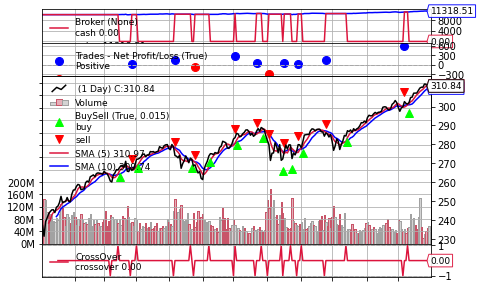

[[<Figure size 432x288 with 5 Axes>]]

In [13]:
%matplotlib inline
cerebro.plot(iplot=False)

<IPython.core.display.Javascript object>

[[<Figure size 432x288 with 4 Axes>]]

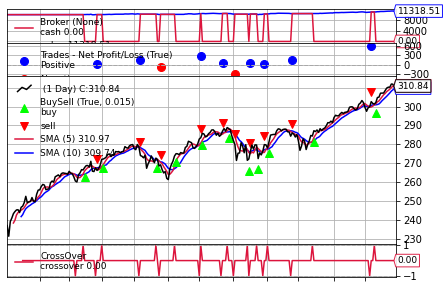

In [14]:
cerebro.plot(volume=False, savefig=True, figfilename='backtrader-plot.png')

In [17]:
def saveplots(cerebro, numfigs=1, iplot=True, start=None, end=None,
             width=16, height=30, dpi=300, tight=True, use=None, file_path = '', **kwargs):

        from backtrader import plot
        if cerebro.p.oldsync:
            plotter = plot.Plot_OldSync(**kwargs)
        else:
            plotter = plot.Plot(**kwargs)

        figs = []
        for stratlist in cerebro.runstrats:
            for si, strat in enumerate(stratlist):
                rfig = plotter.plot(strat, figid=si * 100,
                                    numfigs=numfigs, iplot=iplot,
                                    start=start, end=end, use=use)
                figs.append(rfig)

        for fig in figs:
            for f in fig:
                f.savefig(file_path, bbox_inches='tight')
        return figs